In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from collections import defaultdict
import pickle

In [2]:


from postanalysis_utils import load_exp_artifacts
exp_name = "scientific_arena_8562"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, args, ds_args = load_exp_artifacts(exp_name, device, only_args=False)

2023-10-10 18:26:06.906288: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 18:26:06.957654: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Non-overridden ds_args: ['add_df_to_line_info', 'add_df_to_line_info_before_encoder', 'backbone', 'crop_type', 'decoder_attention_type', 'do_attend_line_info', 'do_overfit', 'do_save_model', 'ds', 'exp_disabled', 'exp_name', 'exp_tags', 'global_step', 'load_previos_args', 'lr', 'max_depth_eval', 'min_depth_eval', 'min_length', 'num_epochs', 'num_workers', 'resume_epoch', 'resume_exp', 'return_deeplsd_embedding', 'save_freq_epochs', 'target_shape', 'use_attn', 'use_attn_before_se', 'use_df_as_feature_map', 'use_df_as_self_attn_pos_embed', 'use_df_to_postproc_depth', 'use_dnet', 'use_eigen', 'use_extra_conv', 'use_full_ds', 'use_single_sample', 'vis_freq_epochs', 'window_size']


In [3]:

from layout_aware_monodepth.train_prototyping import create_dataloaders
ds_args.filenames_file = '../data/data_splits/kitti_dc_partitioned.json'
args.num_workers = 0
# ds_args.line_embed_channels = None
# ds_args.line_op = None
# args.line_embed_channels = None
train_ds, train_loader, val_loader, test_loader = create_dataloaders(args, ds_args)
x = train_ds[0]
batch = next(iter(train_loader))
assert len(batch['image']) == 1
val_loader.num_workers=0
test_loader.num_workers=0

In [4]:
img, d = x["image"], x["depth"]
img.shape, d.shape

(torch.Size([3, 256, 768]), (1, 256, 768))

In [ ]:
# batch = torch.load('./batch.pt')

In [7]:
res = model(batch['image'].to(device), batch["line_embed"].to(device))
# res = model(batch['image'].to(device), batch["line_embed"].to(device))
res.shape

torch.Size([1, 1, 256, 768])

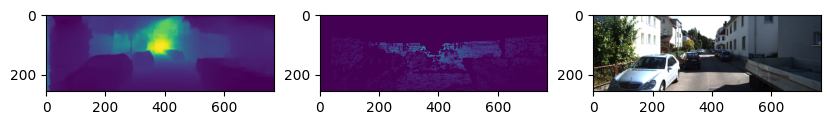

In [9]:
# plt.imshow(res[0].detach().cpu().numpy().squeeze())
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(res[0].detach().cpu().numpy().squeeze())
axs[1].imshow(batch['depth'][0].detach().cpu().numpy().squeeze())
axs[2].imshow(batch['image'][0].detach().cpu().numpy().transpose(1, 2, 0).squeeze())

In [15]:

from layout_aware_monodepth.metrics import get_metrics


get_metrics(
        res, batch['depth'], max_depth=80, min_depth=1e-3, crop_type=None, ds_name='kitti'
    )

{'abs_rel': 0.06139402,
 'rmse': 2.6888604,
 'mae': 1.375259,
 'sq_rel': 0.17363903,
 'rmse_log': 0.08400556,
 'delta1': 0.9810138248847926,
 'delta2': 0.9980645161290322,
 'delta3': 1.0,
 'log_10': 0.027338224,
 'silog': 7.379735648095684}

In [ ]:
raise Exception("Proceed to get top-10 best/worst results")

In [9]:
from layout_aware_monodepth.losses import SILogLoss
from layout_aware_monodepth.trainer import Trainer

criterion = SILogLoss()
trainer = Trainer(
    args,
    model,
    optimizer=None,
    criterion=criterion,
    device=device,
)

In [11]:
import gc
import os
from layout_aware_monodepth.metrics import RunningAverageDict

for loader, alias in [(test_loader, "test")]:
# for loader, alias in [(val_loader, "val"), (test_loader, "test")]:
    batch_bar = tqdm(total=len(loader), leave=True)
    metrics_avg = RunningAverageDict()

    best_top_10_samples = defaultdict(list)
    worst_top_10_samples = defaultdict(list)
    best_top_10_metrics = defaultdict(list)
    worst_top_10_metrics = defaultdict(list)

    running_losses = []
    for i, batch in enumerate(loader):
        step_res = trainer.eval_step(model, batch, criterion)
        running_losses.append(step_res["loss"])
        batch_bar.update(1)
        metrics = {f"{alias}_{k}": v for k, v in step_res.items() if k not in ["pred"]}
        for k, v in metrics.items():
            log_sample = {
                "image": batch["image"].cpu(),
                "depth": batch["depth"].cpu(),
                "line_embed": batch.get("line_embed"),
                "pred": step_res["pred"].cpu(),
                "metric": v,
            }

            # only first batch
            if len(best_top_10_metrics[k]) < 10:
                best_top_10_metrics[k].append(v)
                worst_top_10_metrics[k].append(v)
                best_top_10_samples[k].append(log_sample)
                worst_top_10_samples[k].append(log_sample)
                continue

            is_higher_better = k.split('_')[1] in [
                "delta1",
                "delta2",
                "delta3",
            ]
            if is_higher_better:
                is_better = any([v > m for m in best_top_10_metrics[k]])
                is_worse = any([v < m for m in worst_top_10_metrics[k]])
            else:
                is_better = any([v < m for m in best_top_10_metrics[k]])
                is_worse = any([v > m for m in worst_top_10_metrics[k]])

            # assert not (is_better and is_worse)
            if is_better:
                if is_higher_better:
                    idx_to_replace = np.argmin(best_top_10_metrics[k])
                else:
                    idx_to_replace = np.argmax(best_top_10_metrics[k])
                best_top_10_samples[k][idx_to_replace] = log_sample
                best_top_10_metrics[k][idx_to_replace] = v
            if is_worse:
                if is_higher_better:
                    idx_to_replace = np.argmax(worst_top_10_metrics[k])
                else:
                    idx_to_replace = np.argmin(worst_top_10_metrics[k])
                worst_top_10_samples[k][idx_to_replace] = log_sample
                worst_top_10_metrics[k][idx_to_replace] = v
        metrics_avg.update(metrics)
        batch_bar.set_postfix(**metrics)

    benchmark_res = {
        "best_top_10_samples": best_top_10_samples,
        "worst_top_10_samples": worst_top_10_samples,
        "best_top_10_metrics": best_top_10_metrics,
        "worst_top_10_metrics": worst_top_10_metrics,
    }

    save_dir = f"../artifacts/{exp_name}/"
    os.makedirs(save_dir, exist_ok=True)
    with open(f"{save_dir}/benchmark_res_{alias}.pkl", "wb") as f:
        pickle.dump(benchmark_res, f)

    del benchmark_res
    gc.collect()

    batch_bar.close()

100%|██████████| 652/652 [03:08<00:00,  3.46it/s, test_abs_rel=0.0753, test_delta1=0.936, test_delta2=0.995, test_delta3=0.999, test_log_10=0.0322, test_loss=1.14, test_mae=112, test_rmse=218, test_rmse_log=0.115, test_silog=11.4, test_sq_rel=22.2]   


: 